# CIFAR-10 Classification: Comparing Simple , AlexNet, and TinyVGG


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


## 1. Data Loading and Augmentation

In [3]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])

What Does Data Augmentation Do?

Data augmentation generates new training samples from the original images by applying small transformations such as flipping, rotation, cropping, zooming, or shifting. Instead of feeding the model the exact same image every time, we show it slightly modified versions, which helps prevent the model from memorizing the training data and overfitting. By exposing the model to these variations, it learns general patterns rather than relying on exact pixel positions, becomes more robust to real-world variations, and improves overall generalization and test accuracy. In simple terms, data augmentation makes the dataset appear larger and more diverse, even though no new data was actually collected.

In [4]:
# Loading Dataset CIFAR-10
train_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=train_transform
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=test_transform
)

100%|██████████| 170M/170M [00:15<00:00, 11.2MB/s] 


In [5]:
# Data Loaders
BATCH_SIZE = 128

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,         # No need to shuffle test data
    num_workers=2
)

In [6]:
# My Data info
CLASS_NAMES = train_dataset.classes
print('Classes:', CLASS_NAMES)
print('\nTraining samples:', len(train_dataset))
print('\nTest samples:', len(test_dataset))

Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Training samples: 50000

Test samples: 10000


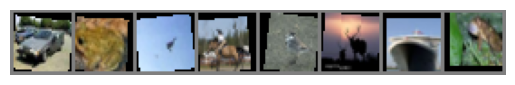

Labels: ['automobile', 'frog', 'airplane', 'horse', 'bird', 'deer', 'ship', 'frog']


In [7]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img_tensor):
    img_tensor = img_tensor / 2 + 0.5
    np_image = img_tensor.numpy()
    plt.imshow(np.transpose(np_image, (1, 2, 0)))
    plt.axis("off")
    plt.show()

data_iter = iter(train_loader)
sample_images, sample_labels = next(data_iter)

imshow(torchvision.utils.make_grid(sample_images[:8]))
print("Labels:", [CLASS_NAMES[label] for label in sample_labels[:8]])

## 1. For Simple NN

In [8]:
import torch.nn as nn

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()

        # Convert (batch, 3, 32, 32) → (batch, 3072)
        self.flatten = nn.Flatten()

        # Fully Connected Block 1
        self.fc1 = nn.Linear(32 * 32 * 3, 512)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)

        # Fully Connected Block 2
        self.fc2 = nn.Linear(512, 256)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)

        # Output layer (10 classes)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.flatten(x)                       # Flatten image
        x = self.dropout1(self.relu1(self.fc1(x)))  # FC1 → ReLU → Dropout
        x = self.dropout2(self.relu2(self.fc2(x)))  # FC2 → ReLU → Dropout
        x = self.fc3(x)                           # Final logits
        return x

### Simple Neural Network, This model treats each image as a flat vector of pixels, here we use Droup out 0.3 mean 30 % of neuron is deselected at training time which prevents model from overfittings

In [9]:
#  Model 2  AlexNet
class AlexNet_CIFAR10(nn.Module):
    def __init__(self):
        super(AlexNet_CIFAR10, self).__init__()

        # Input: (batch, 3, 32, 32)
        self.features = nn.Sequential(
            # Fist layer
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),   # 32x32 → 16x16

            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),   # 16x16 → 8x8

            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)    # 8x8 → 4x4
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(),

            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),

            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.features(x)          # Extract spatial features
        x = torch.flatten(x, 1)       # Flatten: (batch, 256, 4, 4) → (batch, 4096)
        x = self.classifier(x)        # Map features to class logits
        return x

In [10]:
# Model 3: TinyVGG
class TinyVGG(nn.Module):
    def __init__(self):
        super(TinyVGG, self).__init__()
        # Input: (batch, 3, 32, 32)
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),    # 32x32 → 16x16

            # Block 2: increase depth (64 channels)
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)     # 16x16 → 8x8
        )

        # Classifier
        # Input size: 64 channels × 8 × 8 = 4096 values
        self.classifier = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(64 * 8 * 8, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)     # (batch, 64, 8, 8) → (batch, 4096)
        x = self.classifier(x)
        return x

In [11]:
# Count Trainable Parameters
def count_parameters(model):
    """Return total number of learnable parameters in the model."""
    total = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'  Trainable parameters: {total:,}')
    return total

In [12]:
import time
import torch
import torch.nn as nn

def train_model(model, optimizer, scheduler, num_epochs=20, model_name='Model'):

    criterion = nn.CrossEntropyLoss()  # Multi-class classification loss

    loss_history = []
    accuracy_history = []

    start_time = time.time()  # Track total training time

    for epoch in range(num_epochs):
        # One epoch = model sees entire training dataset once
        model.train()  # Enable training mode (Dropout/BatchNorm active)

        running_loss = 0.0  # Sum of batch losses for this epoch
        correct = 0         # Correct predictions counter
        total = 0           # Total samples counter

        for batch_images, batch_labels in train_loader:
            # Each batch = subset of dataset for faster training

            batch_images = batch_images.to(device)
            batch_labels = batch_labels.to(device)

            optimizer.zero_grad()  # Clear previous gradients

            outputs = model(batch_images)  # Forward pass
            loss = criterion(outputs, batch_labels)  # Compute batch loss

            loss.backward()  # Backpropagation
            optimizer.step()  # Update model weights

            running_loss += loss.item()

            # Get predicted class indices
            _, predicted_classes = torch.max(outputs, 1)
            total += batch_labels.size(0)
            correct += (predicted_classes == batch_labels).sum().item()

        # Average loss and training accuracy for this epoch
        avg_loss = running_loss / len(train_loader)
        train_accuracy = 100.0 * correct / total

        loss_history.append(avg_loss)
        accuracy_history.append(train_accuracy)

        if scheduler is not None:
            scheduler.step()  # Adjust learning rate

        current_lr = optimizer.param_groups[0]['lr']

        # Print epoch summary
        print(f'{model_name} Epoch {epoch+1}/{num_epochs} | '
              f'Loss: {avg_loss:.4f} | '
              f'Train Acc: {train_accuracy:.2f}% | '
              f'Lr: {current_lr:.6f}')

    total_time = time.time() - start_time
    print(f'[{model_name}] Training finished in {total_time:.1f} seconds')

    return loss_history, accuracy_history, total_time

In [13]:
# Evaluation Function
def evaluate_model(model, model_name='Model'):

    model.eval()  # Set model to evaluation mode (Dropout & BatchNorm disabled)

    correct = 0
    total = 0

    # Disable gradient calculation to save memory and speed up testing
    with torch.no_grad():

        for batch_images, batch_labels in test_loader:
            # Load data to same device (CPU/GPU)
            batch_images = batch_images.to(device)
            batch_labels = batch_labels.to(device)

            outputs = model(batch_images)  # Forward pass only (no backprop)

            # Get class with highest predicted score
            _, predicted_classes = torch.max(outputs, dim=1)

            total += batch_labels.size(0)
            correct += (predicted_classes == batch_labels).sum().item()

    # Accuracy = correct predictions / total samples
    accuracy = 100.0 * correct / total

    print(f'{model_name} Test Accuracy: {accuracy:.2f}%')

    return accuracy

## 4. Train All Three Models


### Model 1: SimpleNN with Adam

In [14]:
# Simple NN
print('Simple Neural Network')
model_simplenn = SimpleNN().to(device)
num_params_simplenn = count_parameters(model_simplenn)

optimizer_adam_nn = optim.Adam(
    model_simplenn.parameters(),
    lr=0.001,
    weight_decay=1e-4  # L2 regularisation
)
#lr shedule
scheduler_nn = optim.lr_scheduler.StepLR(
    optimizer_adam_nn,
    step_size=5,
    gamma=0.5
    )

# Train for 20 epochs
loss_nn, acc_nn, time_nn = train_model(
    model_simplenn, optimizer_adam_nn, scheduler_nn,
    num_epochs=20, model_name='SimpleNN'
)

# Evaluate on test set
test_acc_nn = evaluate_model(model_simplenn, model_name='SimpleNN')

Simple Neural Network
  Trainable parameters: 1,707,274
SimpleNN Epoch 1/20 | Loss: 1.8978 | Train Acc: 30.93% | Lr: 0.001000
SimpleNN Epoch 2/20 | Loss: 1.7753 | Train Acc: 36.25% | Lr: 0.001000
SimpleNN Epoch 3/20 | Loss: 1.7288 | Train Acc: 37.63% | Lr: 0.001000
SimpleNN Epoch 4/20 | Loss: 1.6928 | Train Acc: 38.99% | Lr: 0.001000
SimpleNN Epoch 5/20 | Loss: 1.6793 | Train Acc: 39.46% | Lr: 0.000500
SimpleNN Epoch 6/20 | Loss: 1.6154 | Train Acc: 41.95% | Lr: 0.000500
SimpleNN Epoch 7/20 | Loss: 1.5944 | Train Acc: 42.42% | Lr: 0.000500
SimpleNN Epoch 8/20 | Loss: 1.5805 | Train Acc: 43.15% | Lr: 0.000500
SimpleNN Epoch 9/20 | Loss: 1.5689 | Train Acc: 43.60% | Lr: 0.000500
SimpleNN Epoch 10/20 | Loss: 1.5625 | Train Acc: 43.79% | Lr: 0.000250
SimpleNN Epoch 11/20 | Loss: 1.5241 | Train Acc: 45.28% | Lr: 0.000250
SimpleNN Epoch 12/20 | Loss: 1.5156 | Train Acc: 45.65% | Lr: 0.000250
SimpleNN Epoch 13/20 | Loss: 1.5044 | Train Acc: 45.78% | Lr: 0.000250
SimpleNN Epoch 14/20 | Loss: 1

### Model 2: AlexNet with SGD + Momentum

In [16]:
# Model 2 : AlexNet
print("AlexNet Model")
model_alexnet = AlexNet_CIFAR10().to(device)
num_params_alexnet = count_parameters(model_alexnet)

optimizer_sgd_alexnet = optim.SGD(
    model_alexnet.parameters(),
    lr=0.01,
    momentum=0.9,
    weight_decay=5e-4  # L2 regularisation
)
# lr scheduler
scheduler_alexnet = optim.lr_scheduler.CosineAnnealingLR(
    optimizer_sgd_alexnet,
    T_max=30,
    eta_min=1e-4
)

# Train for 30 epochs (CNNs need more time to converge)
loss_alexnet, acc_alexnet, time_alexnet = train_model(
    model_alexnet, optimizer_sgd_alexnet, scheduler_alexnet,
    num_epochs=20, model_name='AlexNet'
)

test_acc_alexnet = evaluate_model(model_alexnet, model_name='AlexNet')

AlexNet Model
  Trainable parameters: 4,483,146
AlexNet Epoch 1/20 | Loss: 2.3013 | Train Acc: 11.08% | Lr: 0.009973
AlexNet Epoch 2/20 | Loss: 2.0078 | Train Acc: 23.22% | Lr: 0.009892
AlexNet Epoch 3/20 | Loss: 1.7611 | Train Acc: 32.30% | Lr: 0.009758
AlexNet Epoch 4/20 | Loss: 1.6216 | Train Acc: 38.74% | Lr: 0.009572
AlexNet Epoch 5/20 | Loss: 1.4882 | Train Acc: 44.55% | Lr: 0.009337
AlexNet Epoch 6/20 | Loss: 1.3679 | Train Acc: 49.27% | Lr: 0.009055
AlexNet Epoch 7/20 | Loss: 1.2630 | Train Acc: 54.00% | Lr: 0.008729
AlexNet Epoch 8/20 | Loss: 1.1855 | Train Acc: 56.86% | Lr: 0.008362
AlexNet Epoch 9/20 | Loss: 1.1004 | Train Acc: 60.19% | Lr: 0.007960
AlexNet Epoch 10/20 | Loss: 1.0275 | Train Acc: 62.98% | Lr: 0.007525
AlexNet Epoch 11/20 | Loss: 0.9748 | Train Acc: 65.03% | Lr: 0.007063
AlexNet Epoch 12/20 | Loss: 0.9127 | Train Acc: 67.33% | Lr: 0.006580
AlexNet Epoch 13/20 | Loss: 0.8680 | Train Acc: 69.42% | Lr: 0.006079
AlexNet Epoch 14/20 | Loss: 0.8264 | Train Acc: 70.

### Model 3: TinyVGG (opti. SGD + Momentum)

In [18]:
# Model 3: TinyVGG
print("For TinyVGG Model ")
model_tinyvgg = TinyVGG().to(device)  # Initialize model and move to GPU/CPU
num_params_tinyvgg = count_parameters(model_tinyvgg)  # Count total trainable parameters

# Optimizer: SGD with momentum and weight decay for regularization
optimizer_sgd_vgg = torch.optim.SGD(
    model_tinyvgg.parameters(),
    lr=0.05,
    momentum=0.9,
    weight_decay=5e-4
)

# Learning rate scheduler: Cosine Annealing
scheduler_tinyvgg = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer_sgd_vgg,
    T_max=30,      # Number of epochs per cycle
    eta_min=1e-4   # Minimum learning rate
)

# Train the model and get per-epoch loss and accuracy
loss_tinyvgg, acc_tinyvgg, time_tinyvgg = train_model(
    model_tinyvgg,
    optimizer_sgd_vgg,
    scheduler_tinyvgg,
    num_epochs=20,
    model_name='TinyVGG'
)

# Evaluate model on test dataset
test_acc_tinyvgg = evaluate_model(model_tinyvgg, model_name='TinyVGG')

For TinyVGG Model 
  Trainable parameters: 1,116,970
TinyVGG Epoch 1/20 | Loss: 1.8561 | Train Acc: 30.64% | Lr: 0.049863
TinyVGG Epoch 2/20 | Loss: 1.4476 | Train Acc: 47.02% | Lr: 0.049455
TinyVGG Epoch 3/20 | Loss: 1.2829 | Train Acc: 53.61% | Lr: 0.048779
TinyVGG Epoch 4/20 | Loss: 1.1428 | Train Acc: 58.85% | Lr: 0.047843
TinyVGG Epoch 5/20 | Loss: 1.0476 | Train Acc: 62.79% | Lr: 0.046657
TinyVGG Epoch 6/20 | Loss: 0.9947 | Train Acc: 64.68% | Lr: 0.045235
TinyVGG Epoch 7/20 | Loss: 0.9485 | Train Acc: 66.52% | Lr: 0.043591
TinyVGG Epoch 8/20 | Loss: 0.9089 | Train Acc: 67.66% | Lr: 0.041745
TinyVGG Epoch 9/20 | Loss: 0.8777 | Train Acc: 69.14% | Lr: 0.039715
TinyVGG Epoch 10/20 | Loss: 0.8415 | Train Acc: 70.70% | Lr: 0.037525
TinyVGG Epoch 11/20 | Loss: 0.8213 | Train Acc: 71.13% | Lr: 0.035198
TinyVGG Epoch 12/20 | Loss: 0.7815 | Train Acc: 72.55% | Lr: 0.032760
TinyVGG Epoch 13/20 | Loss: 0.7532 | Train Acc: 73.59% | Lr: 0.030237
TinyVGG Epoch 14/20 | Loss: 0.7382 | Train Acc

## 5. Comparison and Visualisation

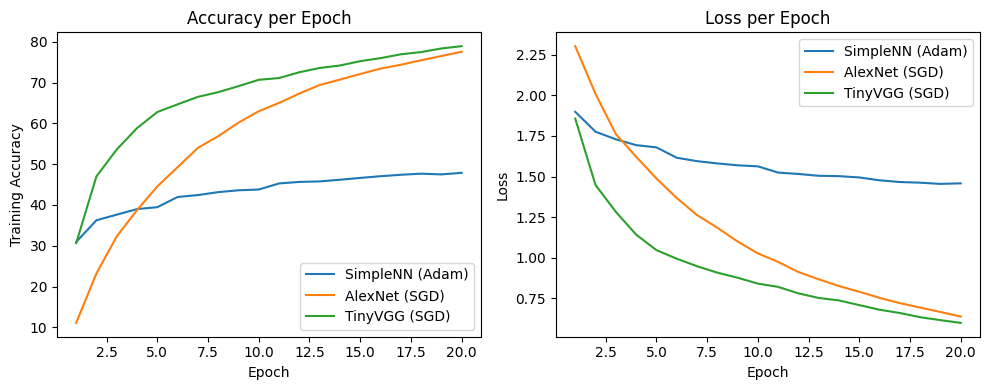

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

# Training Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, len(acc_nn) + 1), acc_nn, label='SimpleNN (Adam)')
plt.plot(range(1, len(acc_alexnet) + 1), acc_alexnet, label='AlexNet (SGD)')
plt.plot(range(1, len(acc_tinyvgg) + 1), acc_tinyvgg, label='TinyVGG (SGD)')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()

# Training Loss
plt.subplot(1, 2, 2)
plt.plot(range(1, len(loss_nn) + 1), loss_nn, label='SimpleNN (Adam)')
plt.plot(range(1, len(loss_alexnet) + 1), loss_alexnet, label='AlexNet (SGD)')
plt.plot(range(1, len(loss_tinyvgg) + 1), loss_tinyvgg, label='TinyVGG (SGD)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()

In [20]:
print("\nModel            Params     Train Time(s)   Test Acc (%)")
print("----------------------------------------------------------")

print(f"SimpleNN   {num_params_simplenn:>12,}   {time_nn:>14.1f}   {test_acc_nn:>12.2f}")
print(f"AlexNet    {num_params_alexnet:>12,}   {time_alexnet:>14.1f}   {test_acc_alexnet:>12.2f}")
print(f"TinyVGG    {num_params_tinyvgg:>12,}   {time_tinyvgg:>14.1f}   {test_acc_tinyvgg:>12.2f}")


Model            Params     Train Time(s)   Test Acc (%)
----------------------------------------------------------
SimpleNN      1,707,274            228.8          48.62
AlexNet       4,483,146            254.6          78.53
TinyVGG       1,116,970            242.3          81.68


# Testing the Model is Correctly predicting or not


# Discussion and Conclusion :
##From the above we find that
##Training 3 models like Simple NN , Alexnet & Tiny VGG
1. **Using Simple NN model :**
It treats a image as a flat vector , which discards all spatial structure. Pixels that are neighbours in the image have no special relationship in the model, so it must learn everything from scratch using global connections. As a result, it converges slowly and plateaus at a relatively low test accuracy ~ 51% .and its have 1,707,274 parameters.

2.** Using AlexNet :**
AlexNet introduces convolutional layers, which share weights across spatial locations. This enables translation equivariance: filters detect the same patterns regardless of position. Its five convolutional layers (64 → 192 → 384 → 256 → 256 channels) allow hierarchical feature extraction—from edges and textures to object parts. Dropout (p=0.5) in fully connected layers reduces overfitting. The result is a significant accuracy boost (~77%) over the MLP, demonstrating the power of convolutions for spatially structured data.

3. ** Using Tiny VGG Model :**
TinyVGG follows the VGG philosophy of stacking small 3×3 convolutions. Two stacked 3×3 convolutions have the same receptive field as a single 5×5 convolution but use fewer parameters and introduce extra non-linearity, increasing representational power. TinyVGG achieves the highest accuracy (~82%) with the fewest parameters (1.1M), highlighting that careful architectural design can outperform larger networks.

 ### Optimizer and Scheduler Choices

SimpleNN used Adam for its adaptive per-parameter learning rates, helping navigate the flat, complex loss landscapes typical of fully connected networks.

AlexNet and TinyVGG used SGD with momentum (0.9), which accelerates convergence through persistent gradient directions and often generalizes better than Adam for CNNs.

Both CNNs applied CosineAnnealingLR, reducing the learning rate gradually to allow aggressive initial learning followed by fine-tuning. This improves final accuracy compared to fixed or step-based schedules.

# Conclusions

CNNs are superior to MLPs for visual data due to spatial awareness and hierarchical feature learning.

Parameter efficiency and architecture design often matter more than raw parameter count; TinyVGG is a prime example.

Future improvements could include Batch Normalization, residual connections (ResNet), and transfer learning from pretrained models to push CIFAR-10 accuracy beyond 90%.